# Image Classificaiton with CNN

In [1]:
# Define the path to the dataset
path = "/kaggle/input/vegetable/Vegetable Classification"

# Task 1: **Data Understanding**

### • How many total images are in the dataset?
### • How balanced is your dataset?i.e. image per class or label

# • How many total images are in the dataset?

In [2]:
train_dir='/kaggle/input/vegetable/Vegetable Classification/Train'

In [4]:
test1_dir='/kaggle/input/vegetable/Vegetable Classification/Test'

In [125]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization,Flatten,Dense
from keras.applications import resnet50
from keras import optimizers
from sklearn.metrics import  classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [6]:
from pathlib import Path

# Create a list of all image file paths
image_paths = []
for p in Path(path).rglob("*.*"):
    if p.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
        image_paths.append(str(p))

# Create a TensorFlow dataset from the image paths
image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)

# Total number of images in the dataset
total_images =  len(image_paths)
print(f"Total number of images in the dataset: {total_images}")

# Total number of images in the training directory
train_images = []
for p in Path(train_dir).rglob("*.*"):
    if p.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
        train_images.append(str(p))

total_train_images = len(train_images)
print(f"Total number of images in the training directory: {total_train_images}")

# Total number of images in the test directory
test_images = []
for p in Path(test1_dir).rglob("*.*"):
    if p.suffix.lower() in ['.jpg', '.jpeg', '.png', '.bmp']:
        test_images.append(str(p))

total_test_images = len(test_images)
print(f"Total number of images in the test directory: {total_test_images}")

Total number of images in the dataset: 6678
Total number of images in the training directory: 6673
Total number of images in the test directory: 5


# How balanced is your dataset?i.e. image per class or label


In [7]:
# Function to check class-wise image counts
class_counts = {}

# Iterate through each directory (assuming each directory represents a class)
for root, dirs, files in os.walk(path):
    # Extract the classes from the directory name
    classes = os.path.basename(root)
    # Count the number of files (images) in the directory
    num_images = len(files)
    # Update the class_counts dictionary
    class_counts[classes] = num_images

# Print the counts for each class
print("Class-wise image counts:")
for classes, count in class_counts.items():
    print(f"{classes}: {count} images")

Class-wise image counts:
Vegetable Classification: 1 images
Test: 5 images
Train: 0 images
Tomato: 1409 images
Bell-Pepper: 1109 images
Lemon: 1471 images
Onion: 1332 images
Potato: 1352 images


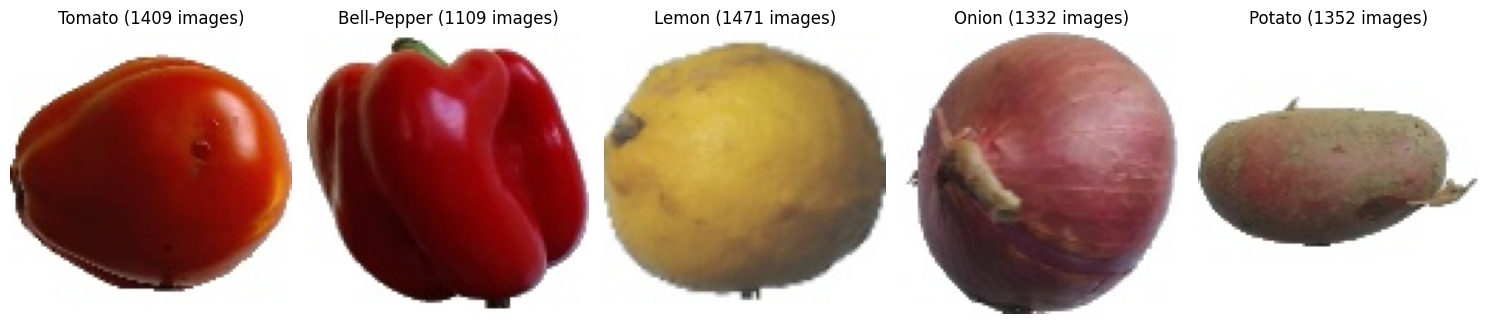

In [8]:
# Count classes in the train_dir
train_class_counts = {}
for class_dir in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_dir)
    class_count = len([f for f in os.listdir(class_path) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
    train_class_counts[class_dir] = class_count

# Visualize one image per class in the training set
num_classes = len(train_class_counts)
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))

if num_classes == 1:
    axes = [axes]

for idx, (cls, count) in enumerate(train_class_counts.items()):
    class_dir = os.path.join(train_dir, cls)
    sample_image_paths = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    if sample_image_paths:
        sample_image_path = sample_image_paths[0]
        sample_image = Image.open(sample_image_path)
        axes[idx].imshow(sample_image)
        axes[idx].set_title(f"{cls} ({count} images)")
        axes[idx].axis('off')
    else:
        axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

# How is your data distributed among train, valid and test set? If not How will you split the dataset among aforementioned folder.

In [9]:
# Specify the path to the image file
image_file = '/kaggle/input/vegetable/Vegetable Classification/Train/Lemon/0_100(1).jpg'

# Function to get the size of an image
def get_image_size(image_path):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            return width, height
    except Exception as e:
        print(f"Error reading file: {image_path}")
        print(e)
        return None, None

# Get the size of the image
width, height = get_image_size(image_file)

# Print the image size
if width and height:
    print(f"Image size: {width} x {height}")
else:
    print("Failed to get image size.")

Image size: 100 x 100


In [10]:
from PIL import Image
# Check for corrupted images and remove them
corrupted_images = []
classes = os.listdir(train_dir)

for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    print(f"Checking directory: {class_dir}")


    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        try:
            img = Image.open(image_path)
            img.verify()  # Verify if image is valid
        except (IOError, SyntaxError) as e:
            corrupted_images.append(image_path)
            os.remove(image_path)  # Remove corrupted image
            print(f"Removed corrupted image: {image_path}")

# Print list of corrupted images if any
if corrupted_images:
    print("Corrupted images found:")
    for image_path in corrupted_images:
        print(image_path)
else:
    print("No corrupted images found.")

Checking directory: /kaggle/input/vegetable/Vegetable Classification/Train/Tomato
Checking directory: /kaggle/input/vegetable/Vegetable Classification/Train/Bell-Pepper
Checking directory: /kaggle/input/vegetable/Vegetable Classification/Train/Lemon
Checking directory: /kaggle/input/vegetable/Vegetable Classification/Train/Onion
Checking directory: /kaggle/input/vegetable/Vegetable Classification/Train/Potato
No corrupted images found.


## 3. Data Pre - processing


In [142]:
!pip install split-folders

import splitfolders

In [145]:
# # Split the dataset into train, validation, and test sets
# splitfolders.ratio(train_dir, output="assessment",
#     seed=200, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values

In [11]:
train_dir = '/kaggle/working/assessment/train'
val_dir = '/kaggle/working/assessment/val'
test_dir  = '/kaggle/working/assessment/test'


In [68]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
target_size = (32,32)

# Data generatoring and rescaling and horizontal flip augmentation for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=15,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

val_datagen   = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
test_datagen  = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,

        class_mode='categorical',
        shuffle=False)

Found 5336 images belonging to 5 classes.
Found 665 images belonging to 5 classes.
Found 672 images belonging to 5 classes.


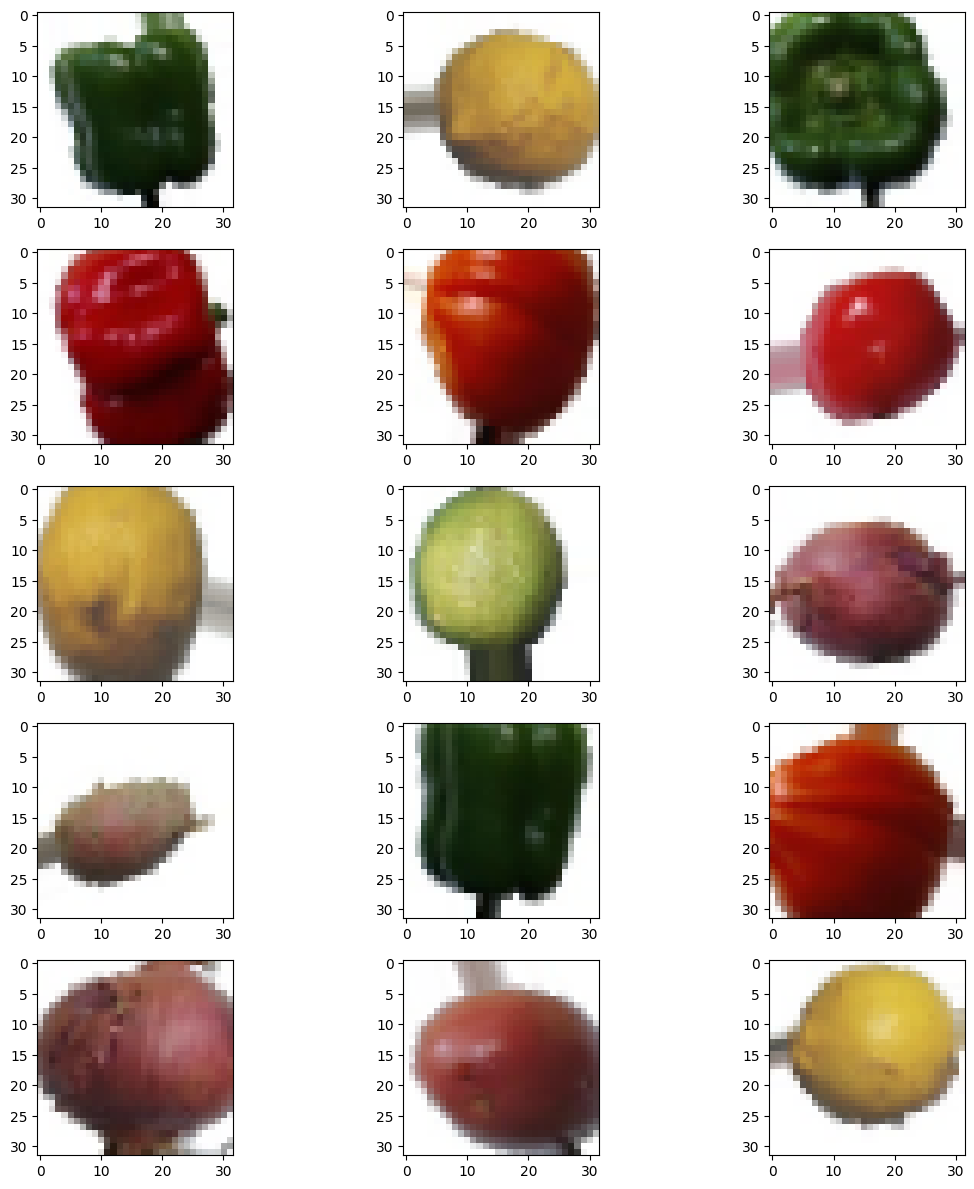

In [17]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [15]:
# printing the class labels from the train generator

labels = list(train_generator.class_indices.keys())
print(labels)

['Bell-Pepper', 'Lemon', 'Onion', 'Potato', 'Tomato']


In [16]:
import os
import cv2  # Import the cv2 module for image processing
import matplotlib.pyplot as plt

#display sample images for each class in the dataset

TRAIN_PATH = train_dir
def sample_images(labels):
    # Create Subplots
    y_size = 15
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 15))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in dataset", x=0.5, y=0.9)

    # Show
    plt.show()

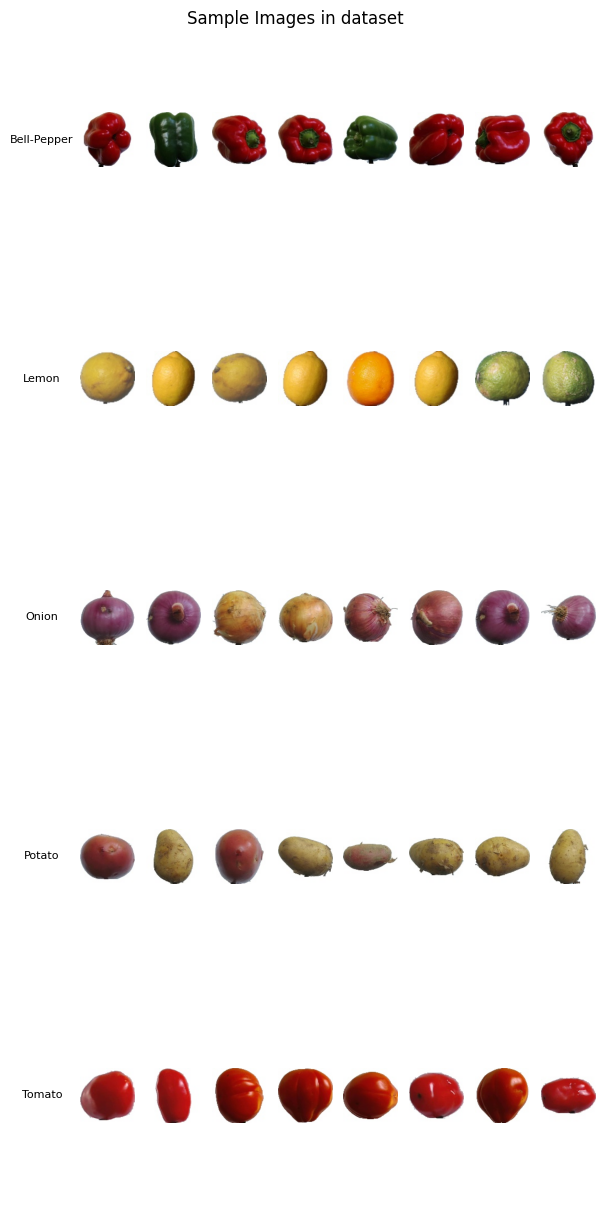

In [18]:
sample_images(labels[:10])

Augmentations

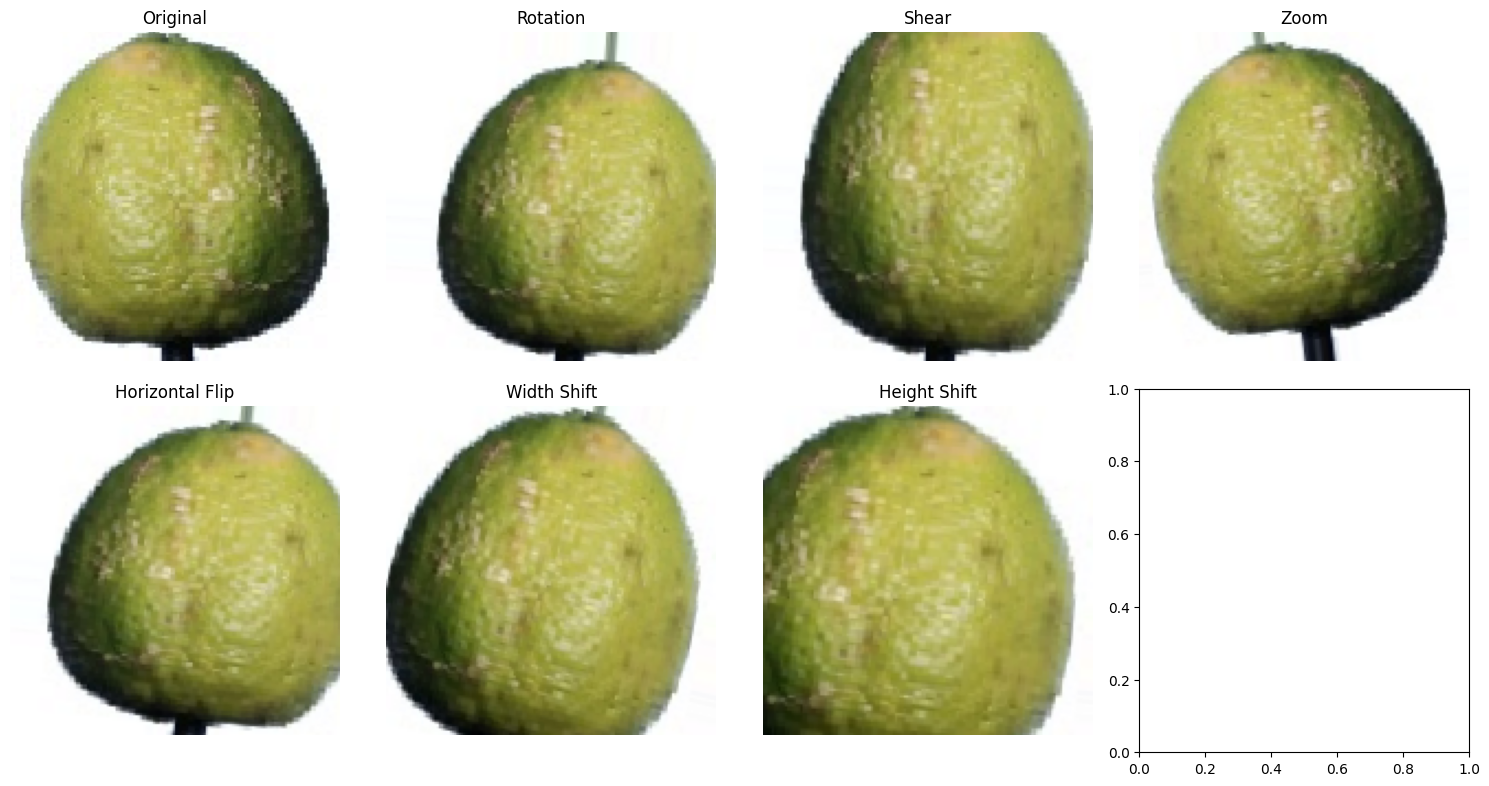

In [154]:
# Load a sample image
img_path = "/kaggle/working/assessment/train/Lemon/297_100(1).jpg"
sample_img = load_img(img_path, target_size=(150, 150))  # Load and resize the image

# Convert the image to a numpy array
x = img_to_array(sample_img)
x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels)

# Define the augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Generate augmented images and plot them
augmentation_styles = [
    'Original',
    'Rotation',
    'Shear',
    'Zoom',
    'Horizontal Flip',
    'Width Shift',
    'Height Shift',
]

# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

# Function to generate and plot augmented image
def generate_and_plot(datagen, title, ax):
    for batch in datagen.flow(x, batch_size=1):
        augmented_img = batch[0]
        ax.imshow(array_to_img(augmented_img))
        ax.set_title(title)
        ax.axis('off')
        break

# Plot the original image
axs[0, 0].imshow(array_to_img(x[0]))
axs[0, 0].set_title('Original')
axs[0, 0].axis('off')

# Iterate over each augmentation style and plot the augmented samples
for i, aug_style in enumerate(augmentation_styles[1:]):
    generate_and_plot(train_datagen, aug_style, axs[(i+1) // 4, (i+1) % 4])

plt.tight_layout()
plt.show()

# Task 2: Building Fully Connected Neural Network.<br>
# **1. Model Building:**


In [19]:
num_classes = len(labels)
input_shape = (32,32,3)
print(num_classes)
print(labels)

5
['Bell-Pepper', 'Lemon', 'Onion', 'Potato', 'Tomato']


In [175]:
# Build an FCNN
fmodel = Sequential([
    Flatten(input_shape=input_shape),  # Flatten the input
    Dense(512, activation='relu'),  # Dense layer
    Dropout(0.2),
    Dense(256, activation='relu'),  # Dense layer
    Dropout(0.2),
    Dense(128, activation='relu'),  # Dense layer
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
fmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,573,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,738,245 (6.63 MB)

 Trainable params: 1,738,245 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [177]:
# Compile Model
fmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [159]:
history = fmodel.fit(train_generator, validation_data=val_generator, batch_size=50 ,epochs=15, callbacks=[early_stop])

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  6/167 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.2143 - loss: 2.4686

W0000 00:00:1715796438.685382     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 45/167 ━━━━━━━━━━━━━━━━━━━━ 23s 193ms/step - accuracy: 0.2904 - loss: 2.0713

W0000 00:00:1715796447.020137     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


159/167 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4368 - loss: 1.4734

W0000 00:00:1715796451.575869     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.4442 - loss: 1.4486 - val_accuracy: 0.8902 - val_loss: 0.3295
Epoch 2/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.7502 - loss: 0.5797 - val_accuracy: 0.9263 - val_loss: 0.2486
Epoch 3/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8225 - loss: 0.4225 - val_accuracy: 0.8812 - val_loss: 0.2808
Epoch 4/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8494 - loss: 0.3710 - val_accuracy: 0.9218 - val_loss: 0.2156
Epoch 5/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8616 - loss: 0.3422 - val_accuracy: 0.9474 - val_loss: 0.1812
Epoch 6/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8630 - loss: 0.3173 - val_accuracy: 0.9669 - val_loss: 0.1164
Epoch 7/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.8723 - loss: 0.3061 - val_accuracy: 0.9669 - val_loss: 0.0949
Epoch 8/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9017 - loss: 0.2493 - val_accuracy: 0.98

In [160]:
scores =fmodel.evaluate(test_generator)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9975 - loss: 0.0171
Test loss:  0.04038668051362038
Test accuracy:  0.9895833134651184


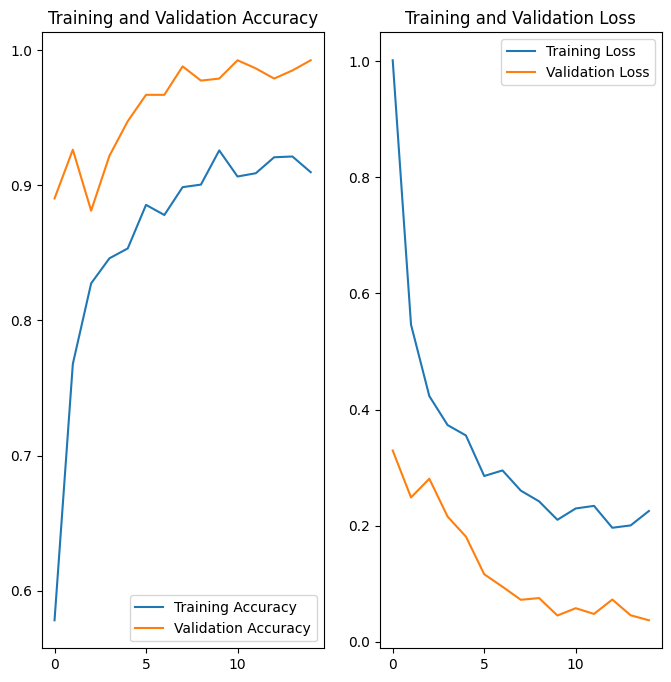

In [161]:
import matplotlib.pyplot as plt

# Assuming history object is available
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


13/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

W0000 00:00:1715796566.132387     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


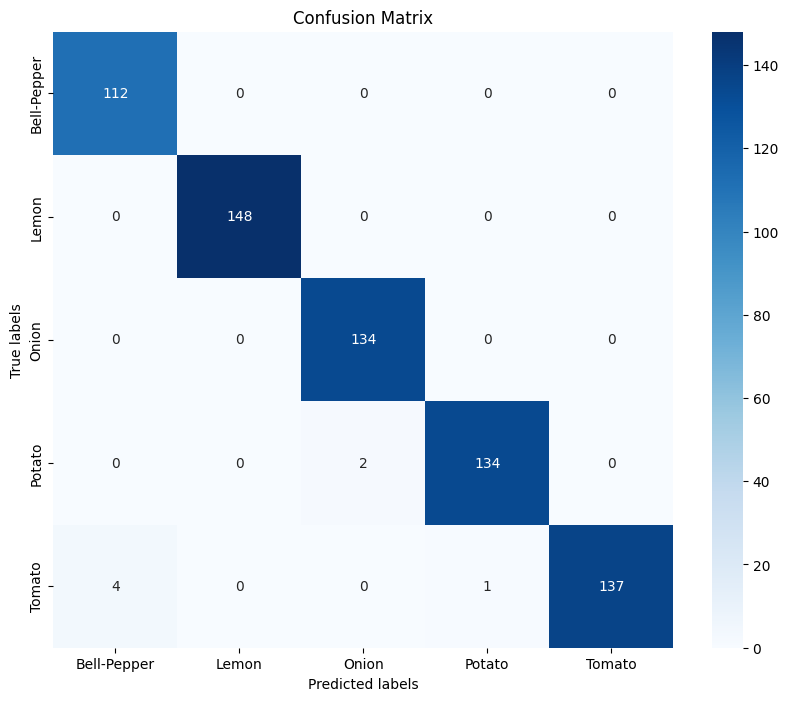

In [163]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Get the predicted labels and true labels
y_pred = fmodel.predict(test_generator)

# Convert the one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)

true_labels = test_generator.classes
# Retrieve class names from the generator
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [164]:
from sklearn.metrics import  classification_report
# Classification Report
a = classification_report(true_labels, y_pred_labels, target_names=class_labels)
print("Classification Report:")
print(a)

Classification Report:
              precision    recall  f1-score   support

 Bell-Pepper       0.97      1.00      0.98       112
       Lemon       1.00      1.00      1.00       148
       Onion       0.99      1.00      0.99       134
      Potato       0.99      0.99      0.99       136
      Tomato       1.00      0.96      0.98       142

    accuracy                           0.99       672
   macro avg       0.99      0.99      0.99       672
weighted avg       0.99      0.99      0.99       672



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


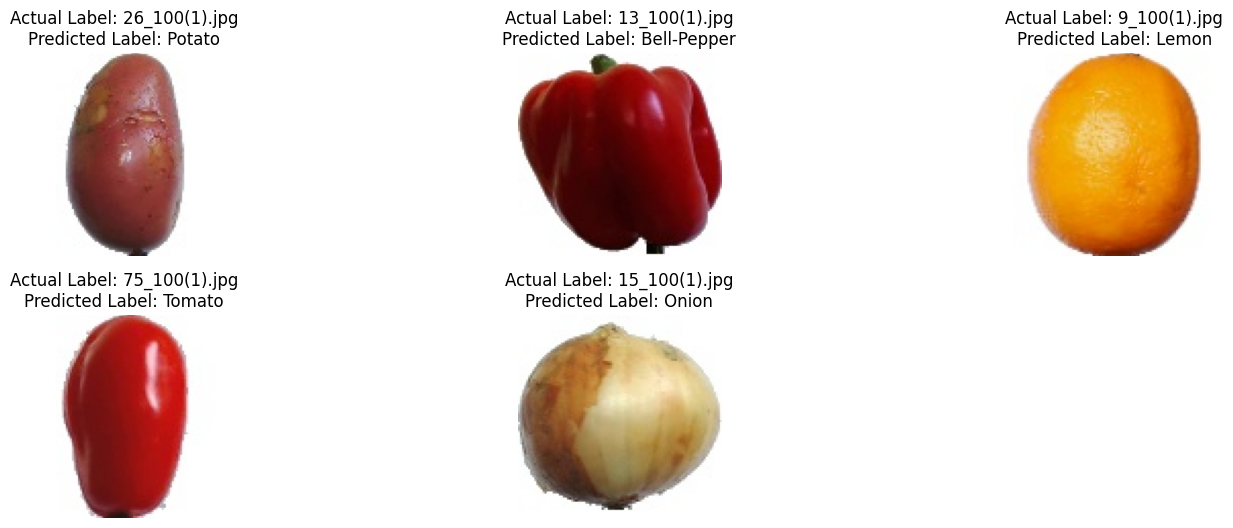

In [165]:
# FCNN model predictions
fcnn_results = []

# Directory containing images
images = []

# Collect all images from the folder
image_paths = os.listdir(test1_dir)

# Get all images in the folder
for img_path in image_paths:
    img = Image.open(os.path.join(test1_dir, img_path))
    images.append(img)

# Predict and store results for FCNN model
for idx, image in enumerate(images):
    # Preprocess the image to match the model's input
    target_size = (32, 32)
    image_array = np.array(image.resize(target_size)) / 255.0
    image_array = image_array.reshape((1, 32, 32, 3))  # Add batch dimension

    # Predict with the FCNN model
    pred = fmodel.predict(image_array)
    predicted_class = class_labels[np.argmax(pred)]  # Assuming you have class_labels defined

    # Store the image and its predicted class
    fcnn_results.append((image, predicted_class))

# Display the images with predictions
plt.figure(figsize=(15, 8))
num_images = len(fcnn_results)
rows = 3
cols = min(num_images, 3)
for i in range(num_images):
    img, predicted_class = fcnn_results[i]
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual Label: {image_paths[i]}\nPredicted Label: {predicted_class}")
plt.tight_layout()
plt.show()

# **CNN Model**

In [40]:
#Building model computational graph
model = Sequential()
model.add(Conv2D(16, (3,3), activation = 'relu', padding = 'same', input_shape = input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

model.add(Dropout(0.3))

model.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2),strides=(2,2)))

model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))

model.add(Dense(num_classes, activation = 'softmax'))


model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 528,741 (2.02 MB)

 Trainable params: 527,749 (2.01 MB)

 Non-trainable params: 992 (3.88 KB)

In [61]:
from keras import backend as K
K.clear_session()

In [121]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [106]:
history = model.fit(train_generator, validation_data=val_generator, epochs=15, callbacks=[early_stop, learning_rate_reduction])

Epoch 1/20
  6/167 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.3607 - loss: 1.5795

W0000 00:00:1715841157.862766     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 88/167 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.6655 - loss: 0.9240

W0000 00:00:1715841161.797937     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


165/167 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7486 - loss: 0.7214

W0000 00:00:1715841165.594165     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.7508 - loss: 0.7159 - val_accuracy: 0.9444 - val_loss: 0.1916 - learning_rate: 0.0010
Epoch 2/20


W0000 00:00:1715841166.413975     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9525 - loss: 0.1539 - val_accuracy: 0.9368 - val_loss: 0.1856 - learning_rate: 0.0010
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9635 - loss: 0.1096 - val_accuracy: 0.9639 - val_loss: 0.1174 - learning_rate: 0.0010
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9738 - loss: 0.0906 - val_accuracy: 0.9744 - val_loss: 0.0915 - learning_rate: 0.0010
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9659 - loss: 0.0919 - val_accuracy: 0.9744 - val_loss: 0.0794 - learning_rate: 0.0010
Epoch 6/20
162/167 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9711 - loss: 0.0739
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9711 - loss: 0.0740 - val_accuracy: 0.9744 - val_loss: 0.0798 - learning_rate: 0.0010
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.9777 - loss: 0.0548 - val_a

In [107]:
scores = model.evaluate(test_generator)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9406 - loss: 0.1668
Test loss:  0.17751789093017578
Test accuracy:  0.9464285969734192


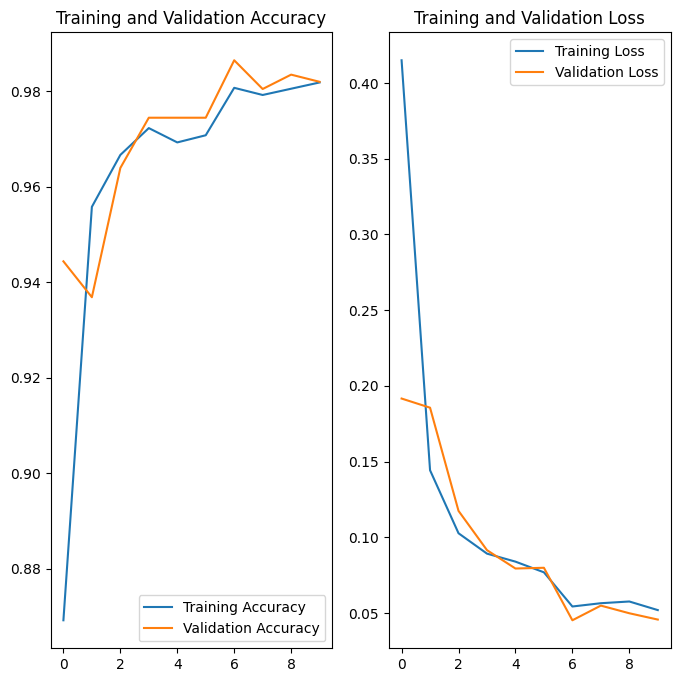

In [108]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


11/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

W0000 00:00:1715841435.452683     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


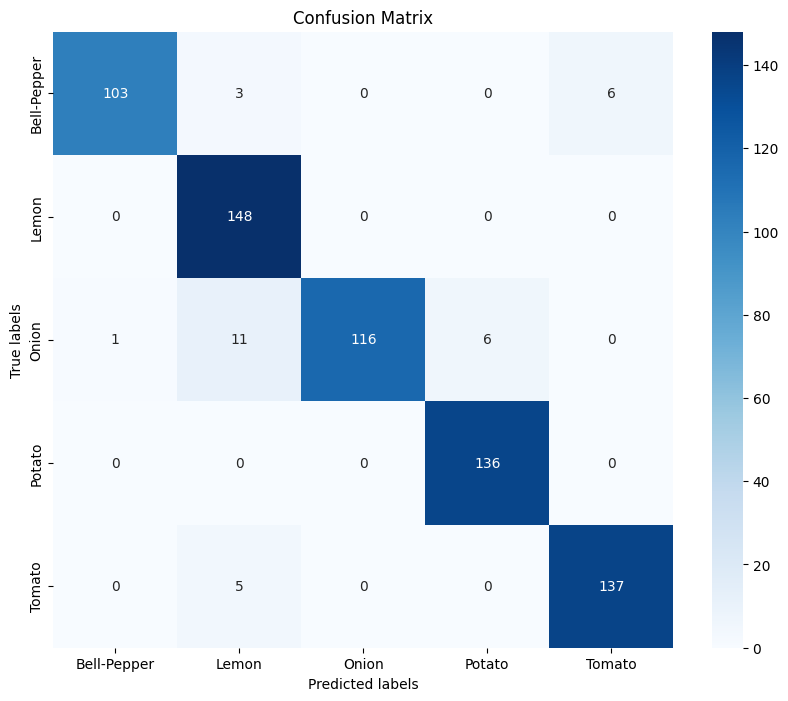

In [112]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the predicted labels and true labels
y_pred = model.predict(test_generator)
# y_true = np.concatenate([y for x, y in test_generator], axis=0)

# Convert the one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)

true_labels = test_generator.classes
# Retrieve class names from the generator
labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)
# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [113]:
from sklearn.metrics import  classification_report
# Classification Report
a = classification_report(true_labels, y_pred_labels, target_names=labels)
print("Classification Report:")
print(a)

Classification Report:
              precision    recall  f1-score   support

 Bell-Pepper       0.99      0.92      0.95       112
       Lemon       0.89      1.00      0.94       148
       Onion       1.00      0.87      0.93       134
      Potato       0.96      1.00      0.98       136
      Tomato       0.96      0.96      0.96       142

    accuracy                           0.95       672
   macro avg       0.96      0.95      0.95       672
weighted avg       0.96      0.95      0.95       672



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


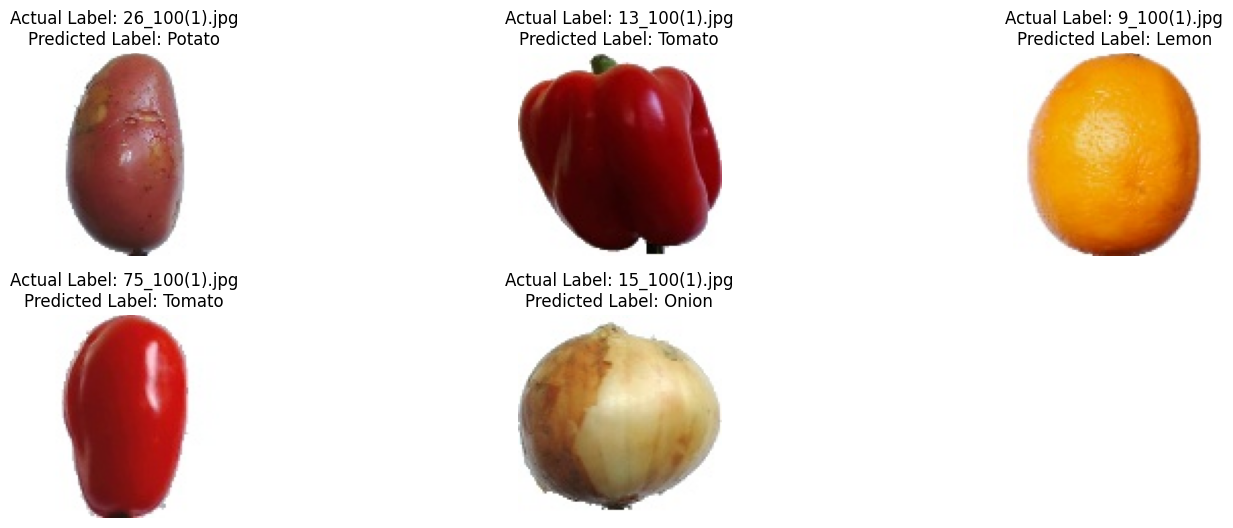

In [116]:
# FCNN model predictions
cnn_results = []

# Directory containing images
images = []

# Collect all images from the folder
image_paths = os.listdir(test1_dir)

# Get all images in the folder
for img_path in image_paths:
    img = Image.open(os.path.join(test1_dir, img_path))
    images.append(img)

# Predict and store results for CNN model
for idx, image in enumerate(images):
    # Preprocess the image to match the model's input
    target_size = (32, 32)
    image_array = np.array(image.resize(target_size)) / 255.0
    image_array = image_array.reshape((1, 32, 32, 3))  # Add batch dimension

    # Predict with the CNN model
    pred = model.predict(image_array)
    predicted_class = labels[np.argmax(pred)]

    # Store the image and its predicted class
    cnn_results.append((image, predicted_class))

# Display the images with predictions
plt.figure(figsize=(15, 8))
num_images = len(cnn_results)
rows = 3
cols = min(num_images, 3)
for i in range(num_images):
    img, predicted_class = cnn_results[i]
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual Label: {image_paths[i]}\nPredicted Label: {predicted_class}")
plt.tight_layout()
plt.show()

# **Transfer Learning**

In [91]:

from tensorflow.keras.applications import VGG16, DenseNet201
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [210]:
conv_base = DenseNet201(weights='imagenet',
                 include_top=False,
                 input_shape=input_shape)

conv_base.trainable=False
        
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(learning_rate=2e-5),
             metrics=['accuracy'])

In [211]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ ?                      │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,321,984 (69.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 18,321,984 (69.89 MB)

In [212]:
history = model.fit(train_generator, validation_data=val_generator, epochs=30, callbacks=[early_stop,learning_rate_reduction])

Epoch 1/30
  5/167 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.2608 - loss: 1.7138   

W0000 00:00:1715797549.022056     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/167 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.5215 - loss: 1.2315

W0000 00:00:1715797565.739521     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5315 - loss: 1.2128

W0000 00:00:1715797581.604492     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715797591.071706     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/167 ━━━━━━━━━━━━━━━━━━━━ 76s 257ms/step - accuracy: 0.5324 - loss: 1.2110 - val_accuracy: 0.8195 - val_loss: 0.6225 - learning_rate: 2.0000e-05
Epoch 2/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.8807 - loss: 0.4648 - val_accuracy: 0.8872 - val_loss: 0.3815 - learning_rate: 2.0000e-05
Epoch 3/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9255 - loss: 0.2874 - val_accuracy: 0.9368 - val_loss: 0.2447 - learning_rate: 2.0000e-05
Epoch 4/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9539 - loss: 0.1923 - val_accuracy: 0.9414 - val_loss: 0.2047 - learning_rate: 2.0000e-05
Epoch 5/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9635 - loss: 0.1566 - val_accuracy: 0.9774 - val_loss: 0.1458 - learning_rate: 2.0000e-05
Epoch 6/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9667 - loss: 0.1347 - val_accuracy: 0.9714 - val_loss: 0.1319 - learning_rate: 2.0000e-05
Epoch 7/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.

In [218]:
scores =model.evaluate(test_generator)
print('Test loss: ', scores[0])
print('Test accuracy: ', scores[1])

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9890 - loss: 0.0458
Test loss:  0.04363977164030075
Test accuracy:  0.9895833134651184


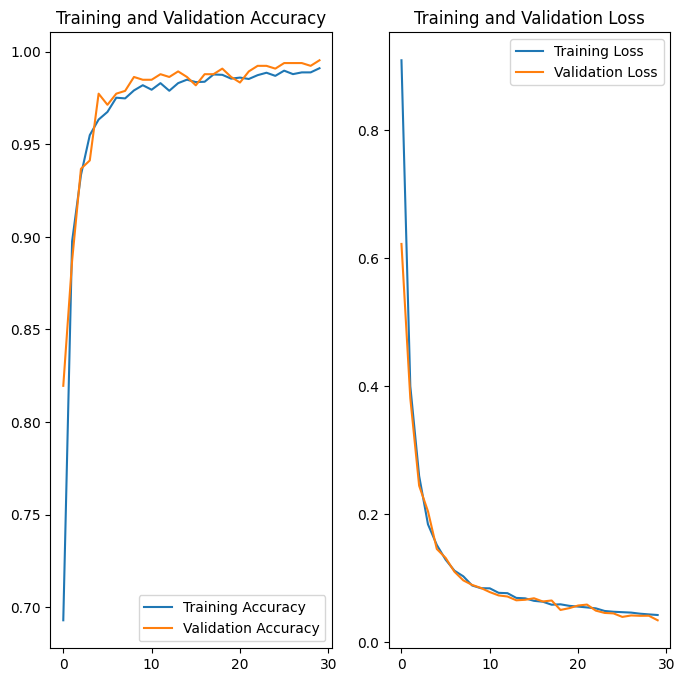

In [214]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


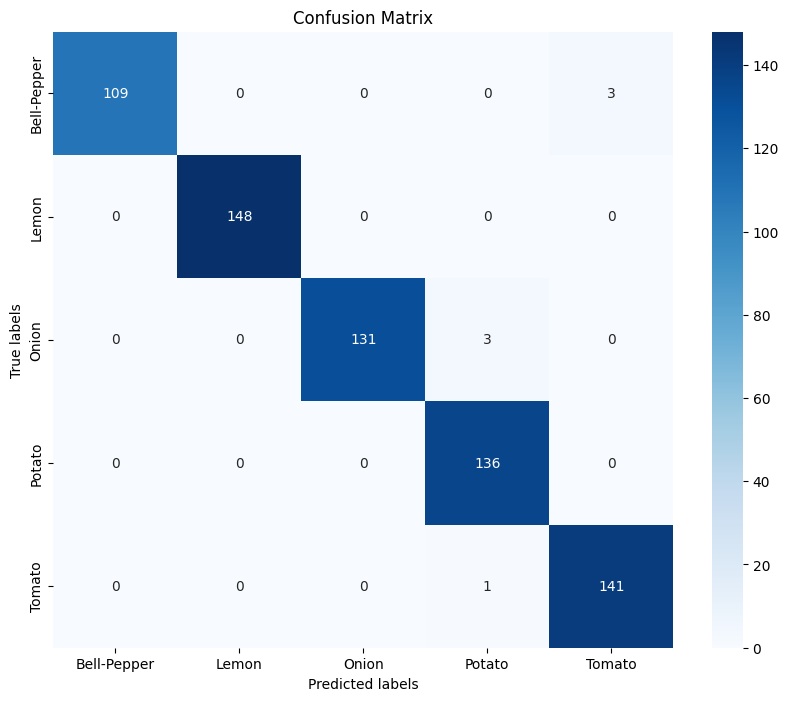

In [219]:
# Get the predicted labels and true labels
y_pred = model.predict(test_generator)

# Convert the one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=-1)

true_labels = test_generator.classes
# Retrieve class names from the generator
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [220]:
# Classification Report
a = classification_report(true_labels, y_pred_labels, target_names=class_labels)
print("Classification Report:")
print(a)

Classification Report:
              precision    recall  f1-score   support

 Bell-Pepper       1.00      0.97      0.99       112
       Lemon       1.00      1.00      1.00       148
       Onion       1.00      0.98      0.99       134
      Potato       0.97      1.00      0.99       136
      Tomato       0.98      0.99      0.99       142

    accuracy                           0.99       672
   macro avg       0.99      0.99      0.99       672
weighted avg       0.99      0.99      0.99       672



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


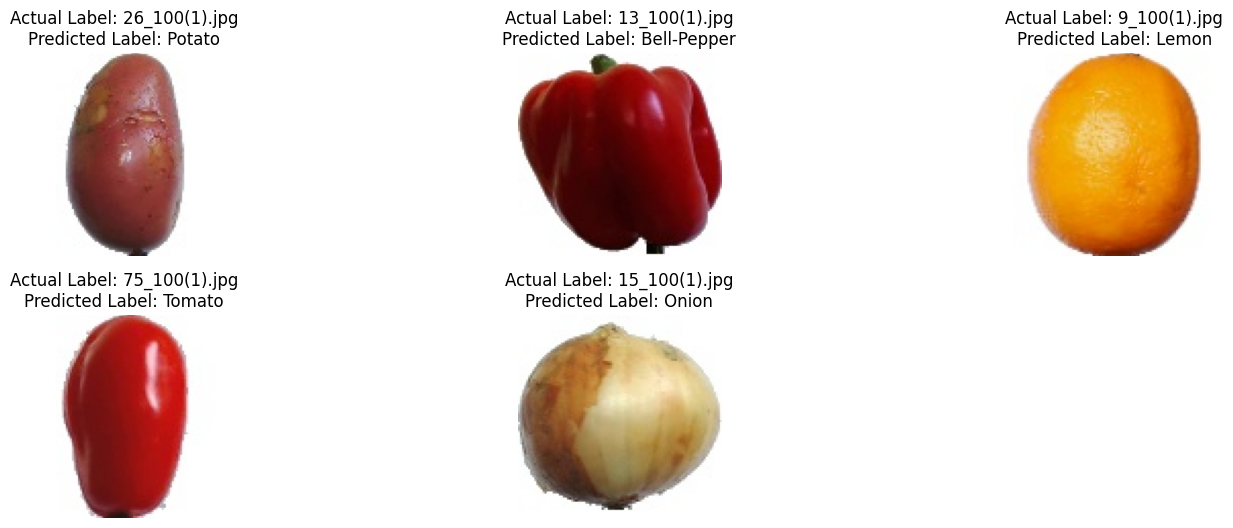

In [221]:
# FCNN model predictions
fcnn_results = []

# Directory containing images
images = []

# Collect all images from the folder
image_paths = os.listdir(test1_dir)

# Get all images in the folder
for img_path in image_paths:
    img = Image.open(os.path.join(test1_dir, img_path))
    images.append(img)

# Predict and store results for FCNN model
for idx, image in enumerate(images):
    # Preprocess the image to match the model's input
    target_size = (32, 32)
    image_array = np.array(image.resize(target_size)) / 255.0
    image_array = image_array.reshape((1, 32, 32, 3))  # Add batch dimension

    # Predict with the FCNN model
    pred = model.predict(image_array)
    predicted_class = class_labels[np.argmax(pred)]  # Assuming you have class_labels defined

    # Store the image and its predicted class
    fcnn_results.append((image, predicted_class))

# Display the images with predictions
plt.figure(figsize=(15, 8))
num_images = len(fcnn_results)
rows = 3
cols = min(num_images, 3)
for i in range(num_images):
    img, predicted_class = fcnn_results[i]
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual Label: {image_paths[i]}\nPredicted Label: {predicted_class}")
plt.tight_layout()
plt.show()